In [1]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

tf_gpu_options = tf.GPUOptions(allow_growth = True) # per_process_gpu_memory_fraction=0.12,
tf_session = tf.Session(config=tf.ConfigProto(gpu_options=tf_gpu_options))
tf.keras.backend.set_session(tf_session)

#biodirectional embedding


/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
# Specify the folder locations
#W2V_DIR = './data/GoogleNews-vectors-negative300.bin' #
GloVe_DIR = './data/glove.twitter.27B.50d.txt'
#the data directory
DATA_DIR = './data'
# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 150 #75(0.68), 150, 300 700(90% but too time comsuming)
MAX_VOCAB_SIZE = 40000 #vocabulary
LSTM_DIM = 100#len(embd[0])
EMBEDDING_DIM = 50 #50 for GloVe 300 for w2v
BATCH_SIZE = 128
N_EPOCHS = 40 #40


basic latm(1):GoogleNews: 75 150(0.7158 for 1 epoch) 300 700||GloVe: 75 150(0.7162 for 1 epoch) 300 700
bidrectional latm:GloVe: 75 150( 0.7141 for 1 epoch) 300 700
Glove+LSTM+ATTENTION(kaddle): 0.7162 for 1 epoch
Glove+LSTM+ATTENTION(attentionsize=15): 0.7162 for 1 epoch

In [3]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

In [4]:
# Read the text files of fnc data
bodies = pd.read_csv(DATA_DIR + '/body_table.csv')
    
train_df = pd.read_csv(DATA_DIR + '/train_data.csv')

#validation_df = pd.read_csv(DATA_DIR + '/validation_data.csv')

test_df = pd.read_csv(DATA_DIR + '/test_data.csv')

In [5]:
train_df.replace('unrelated',1,True)
train_df.replace('agree',2,True)
train_df.replace('disagree',3,True)
train_df.replace('discuss',4,True)

In [6]:
combine_df_train = train_df.join(bodies.set_index('Body ID'), on='Body ID')
combine_df_test = test_df.join(bodies.set_index('Body ID'), on='Body ID')

In [7]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]
word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [8]:
print('90th Percentile Sentence of headline:', np.percentile([len(seq) for seq in word_seq_head_train], 90))

90th Percentile Sentence of headline: 16.0


In [9]:
print('90th Percentile Sentence of body:', np.percentile([len(seq) for seq in word_seq_bodies_train], 50))

90th Percentile Sentence of body: 306.0


In [10]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])



In [11]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
##because it only includes unique words(tokens)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 35375


In [12]:
#combine headline and body together
word_seq_train = [list(i) for i in word_seq_head_train]
for i in range(len(word_seq_head_train)):
    word_seq_train[i].extend(word_seq_bodies_train[i]) 
    
word_seq_test = [list(i) for i in word_seq_head_test]
for i in range(len(word_seq_head_test)):
    word_seq_test[i].extend(word_seq_bodies_test[i]) 


In [13]:
#shorten the sentence to a fixed length
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = combine_df_train['Stance']


In [14]:
# Convert the sequence of words to sequnce of indices
X_test = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_test])
X_test = pad_sequences(X_test, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

In [15]:
# encode class values as integers
encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)


In [16]:
X_train, X_vali, y_train, y_vali = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)

# Build model

In [17]:
# Load the word2vec embeddings 
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)



NameError: name 'W2V_DIR' is not defined

In [18]:
#GloVes Load
glove_input_file = GloVe_DIR
word2vec_output_file = 'glove.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [19]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
        #word 是sentence里的
        #none: if sentence里的word没有对应的pre-trained embedding 那么就有keyerror了
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        #如果存在pre-trained word embedding，那么把这个embedding给到embedding_matrix里
        #embeddings_matrix的第i行对应Wi
        
del embeddings
#delete

In [20]:
# Build a sequential model by stacking neural net units 
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                          mask_zero=True))
#mask_zero is to deal with padding problem
#model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer1'))) #bi(lstm)
model_1.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_1.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
model_1.add(Dense(4, activation='softmax', name='output_layer'))

In [21]:
plot_model(model_1, to_file='bidirectional_model.png', show_layer_names=True, show_shapes=True)

In [55]:
filepath="./result/lstm/epoch40/Bidirectional_lstm_150token_lr0.001_trainable_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list1 = [checkpoint]

In [56]:
#before trainning model, we need to compile it
#use adam optimizer
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train model


In [57]:
#%%capture history
#using different emedding pretrained dataset
history_3 = model_1.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_vali, y_vali),callbacks = callbacks_list1)


Train on 60009 samples, validate on 6668 samples
Epoch 1/40
60009/60009 [==============================] - 177s 3ms/step - loss: 0.7869 - acc: 0.7258 - val_loss: 0.6607 - val_acc: 0.7629
Epoch 2/40
60009/60009 [==============================] - 179s 3ms/step - loss: 0.5995 - acc: 0.7796 - val_loss: 0.4960 - val_acc: 0.8134
Epoch 3/40
60009/60009 [==============================] - 205s 3ms/step - loss: 0.4726 - acc: 0.8236 - val_loss: 0.4283 - val_acc: 0.8410
Epoch 4/40
60009/60009 [==============================] - 255s 4ms/step - loss: 0.3872 - acc: 0.8553 - val_loss: 0.3638 - val_acc: 0.8634
Epoch 5/40
60009/60009 [==============================] - 250s 4ms/step - loss: 0.3262 - acc: 0.8747 - val_loss: 0.3183 - val_acc: 0.8763
Epoch 6/40
60009/60009 [==============================] - 248s 4ms/step - loss: 0.2755 - acc: 0.8948 - val_loss: 0.2759 - val_acc: 0.8931
Epoch 7/40
60009/60009 [==============================] - 248s 4ms/step - loss: 0.2352 - acc: 0.9079 - val_loss: 0.2604 - v

In [58]:
with open('./history/history(bidirectional_lstm_epoch40_150_lr0.001_trainable)', 'wb') as file_pi:
        pickle.dump(history_3.history, file_pi)

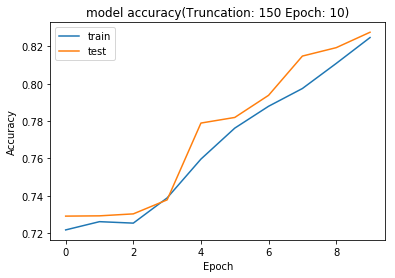

In [111]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy(Truncation: 150 Epoch: 10)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [18]:
from keras import models

In [22]:
model_file_path = './result/attention/epoch_40/FNC-1_LSTM_Attention_15Atlength_150_39_0.9318.h5'
model = models.load_model(model_file_path,custom_objects = {'Attention': Attention()})

h_state (?, 128)


In [23]:
len(X_test)

6270

In [24]:
preds = model.predict(X_test)

In [25]:
outputs = [np.argmax(p, axis = -1) for p in preds]

In [26]:
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "agree"
    if outputs[i] == 3: outputs[i] = "discuss"


In [27]:
df_predicted = {}
df_predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([test_df, df_predicted], axis=1, sort=False)
result.to_csv('./test_LSTM_Attention_split.csv', index=False, encoding='utf-8')

# Improving the model with and Batch-Normalization and Droupouts
two more dense layers


In [20]:
# Build a sequential model by stacking neural net units 
#dense layer: simply a layer connect units 
#dropout layer: for reduce overfitting a regularization methhod
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer')) # Can try Bidirectional-LSTM

#model.add(Dense(32, name='dense_1'))
# model.add(BatchNormalization(name='bn_1')) # BN did not really help with performance 
model.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
model.add(Activation(activation='relu', name='activation_1'))

#model.add(Dense(8, name='dense_2'))
# model.add(BatchNormalization(name='bn_2'))
model.add(Dropout(rate=0.2, name='dropout_2'))
model.add(Activation(activation='relu', name='activation_2'))

model.add(Dense(4, activation='softmax', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1768800   
_________________________________________________________________
lstm_layer (LSTM)            (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 404       
Total para

In [ ]:
#CALLBACK FUCTION: TO SAVE MODEL FOR EVERY EPOCH END
filepath="./saved_models/FNC-1_BASIC_LSTM_150_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list = [checkpoint]

In [26]:
optimizer = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [27]:
history = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_vali, y_vali)
         )



Train on 60009 samples, validate on 6668 samples
Epoch 1/40
60009/60009 [==============================] - 92s 2ms/step - loss: 0.7785 - acc: 0.7263 - val_loss: 0.7134 - val_acc: 0.7308
Epoch 2/40
60009/60009 [==============================] - 91s 2ms/step - loss: 0.7053 - acc: 0.7345 - val_loss: 0.6260 - val_acc: 0.7566
Epoch 3/40
60009/60009 [==============================] - 90s 2ms/step - loss: 0.6452 - acc: 0.7481 - val_loss: 0.5710 - val_acc: 0.7774
Epoch 4/40
60009/60009 [==============================] - 90s 2ms/step - loss: 0.5907 - acc: 0.7670 - val_loss: 0.5280 - val_acc: 0.7933
Epoch 5/40
60009/60009 [==============================] - 90s 2ms/step - loss: 0.5737 - acc: 0.7754 - val_loss: 0.5436 - val_acc: 0.7828
Epoch 6/40
60009/60009 [==============================] - 90s 2ms/step - loss: 0.5431 - acc: 0.7885 - val_loss: 0.5037 - val_acc: 0.8067
Epoch 7/40
60009/60009 [==============================] - 91s 2ms/step - loss: 0.5051 - acc: 0.8032 - val_loss: 0.4731 - val_acc:

FileNotFoundError: [Errno 2] No such file or directory: '../history/history(lstm_dropout+relu_epoch40_150_lr0.002_trainable)'

In [28]:
with open('./history/history(lstm_dropout+relu_epoch40_150_lr0.002_trainable)', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Load Saved Model to Predict


In [ ]:
from keras import models

In [ ]:
model_file_path = 'saved_models/FNC-1_BASIC_LSTM_150_0.7162.h5'
model = models.load_model(model_file_path)

In [ ]:
preds = model.predict()

# lstm + Attention

In [20]:
#reference: https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043/code
#only attend first 15 states
#I tried to combine the first 15states and last satates but I failed
#I could not get to know the last cell state
class Attention(Layer):
    def __init__(self, attention_length = 20 ,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                  **kwargs):

        #self.supports_masking = True
        #Xavier uniform initializer
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.attention_length = 30
        self.features_dim = 100 
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        
        
        self.Wy = self.add_weight((self.features_dim,self.features_dim),
                                 initializer=self.init,
                                 name='{}_Wy'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        

        
        self.Wh = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wh'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.w = self.add_weight((self.features_dim,1),
                                     initializer=self.init,
                                     name='{}_x'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.Wp = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wp'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)
        
        self.Wx = self.add_weight((self.features_dim,self.features_dim),
                                     initializer=self.init,
                                     name='{}_Wx'.format(self.name),
                                     regularizer=self.W_regularizer,
                                     constraint=self.W_constraint)

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        
        Y_states = tf.slice(x, begin = [0, 0, 0], size = [-1, self.attention_length, -1]) #15 first states
        h_state = x[:,-1,:]
        print ("h_state",h_state.shape)
        #print ("wh", self.Wh.shape)
        features_dim = self.features_dim

        M1 = K.reshape(K.dot(K.reshape(Y_states, (-1, features_dim)), self.Wy),shape = (-1,self.attention_length,features_dim ))
        #print("here")
        M2 = K.expand_dims(K.dot(h_state, self.Wh),axis=1)
        M = K.tanh(M1+M2)
        #print("here2")
        alpha = K.reshape(K.softmax(K.dot(K.reshape(M, shape = (-1, features_dim)), self.w)), shape = (-1, self.attention_length))
        r = tf.squeeze(tf.matmul(tf.transpose(tf.expand_dims(alpha, 2), perm = [0, 2, 1]), Y_states))
        h_star = tf.tanh(tf.matmul(r, self.Wp) + tf.matmul(h_state, self.Wx))
        

        return h_star

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim
        


In [21]:
# Build a sequential model by stacking neural net units 
#dense layer: simply a layer connect units 
#dropout layer: for reduce overfitting a regularization methhod
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1, input_length = MAX_SENT_LEN,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable= True, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model_2.add(LSTM(LSTM_DIM, return_sequences=True, name='lstm_layer')) # Can try Bidirectional-LSTM
model_2.add(Dropout(rate=0.8, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.2
#model.add(Activation(activation='relu', name='activation_1'))
#output (batch_size, timesteps, input_dim)
model_2.add(Attention())
model_2.add(Dense(4, activation='softmax', name='output_layer'))

h_state (?, 100)


In [22]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 300, 50)           1768800   
_________________________________________________________________
lstm_layer (LSTM)            (None, 300, 100)          60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
attention_1 (Attention)      (None, 100)               40100     
_________________________________________________________________
output_layer (Dense)         (None, 4)                 404       
Total params: 1,869,704
Trainable params: 1,869,704
Non-trainable params: 0
_________________________________________________________________


In [23]:
optimizer = optimizers.Adam(lr=0.001) # Try a different learning rate

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [24]:
#CALLBACK FUCTION: TO SAVE MODEL FOR EVERY EPOCH END
filepath="./result/attention/epoch_40/FNC-1_LSTM_Attention_15Atlength_300_trainable_lr=0.001_{epoch:02d}_{val_acc:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc', 
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list2 = [checkpoint]

In [27]:
#%%capture history_12
# history1 = model_1.fit(X_train, y_train,
#           batch_size=BATCH_SIZE,
#           epochs=N_EPOCHS,
#           validation_data=(X_vali, y_vali),
#           callbacks = callbacks_list1)
history2 = model_2.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_vali, y_vali),
          callbacks = callbacks_list2)

        


Train on 60009 samples, validate on 6668 samples
Epoch 1/40
60009/60009 [==============================] - 189s 3ms/step - loss: 0.4950 - acc: 0.8130 - val_loss: 0.4397 - val_acc: 0.8358
Epoch 2/40
60009/60009 [==============================] - 189s 3ms/step - loss: 0.4097 - acc: 0.8455 - val_loss: 0.3927 - val_acc: 0.8505
Epoch 3/40
60009/60009 [==============================] - 189s 3ms/step - loss: 0.3535 - acc: 0.8666 - val_loss: 0.3542 - val_acc: 0.8721
Epoch 4/40
60009/60009 [==============================] - 189s 3ms/step - loss: 0.3118 - acc: 0.8831 - val_loss: 0.3409 - val_acc: 0.8697
Epoch 5/40
60009/60009 [==============================] - 189s 3ms/step - loss: 0.2818 - acc: 0.8943 - val_loss: 0.3128 - val_acc: 0.8827
Epoch 6/40
60009/60009 [==============================] - 189s 3ms/step - loss: 0.2552 - acc: 0.9032 - val_loss: 0.2914 - val_acc: 0.8902
Epoch 7/40
60009/60009 [==============================] - 190s 3ms/step - loss: 0.2291 - acc: 0.9136 - val_loss: 0.2729 - v

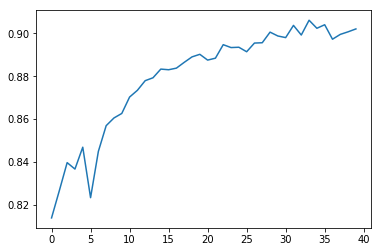

In [72]:
plt.plot(history2['val_acc'])